# Variational Monte Carlo
### For a 4 Particle System

In [173]:
import numpy as np
import random
import math
from matplotlib import pyplot as plt
from IPython.display import clear_output
from math import exp

from pdb import set_trace

In [174]:
# 1 is up and 0 is down
# these are all the possible ground configurations that might
# contribute to the ground states

# this version makes it readable
states = np.asarray([
    [1, 1, 0, 0],
    [0, 0, 1, 1],
    [1, 0, 1, 0],
    [0, 1, 0, 1],
    [1, 0, 0, 1],
    [0, 1, 1, 0],
])

# this line turns all the 0s to -1s for computational purposes
states = states*2 - 1; states

array([[ 1,  1, -1, -1],
       [-1, -1,  1,  1],
       [ 1, -1,  1, -1],
       [-1,  1, -1,  1],
       [ 1, -1, -1,  1],
       [-1,  1,  1, -1]])

In [175]:
def get_random_state():
    return random.choice(states)

In [176]:
def get_variational_projection(state, alpha):
    """
    This function computes the projection of state in the spin basis
    onto the varitional wave function
    """
    exponent = 0 
    # FOO DO WE COUNT THE SUMS TWICE?
    for i in range(len(state)):
        for j in range(0, len(state)):
            if i is not j:
                new_exp_term = (alpha/(min(abs(i-j),abs((i-len(state)) - j), abs(i - (j-len(state))))))*state[i]*state[j]/4 # need the "/4" because spin 1/2 particles
                exponent += new_exp_term
    return math.exp(exponent)

In [177]:
get_variational_projection(states[0], 1)

0.6065306597126334

In [178]:
def get_off_diagonal_configurations(state):
    """
    This function generates a list of configurations that could
    be flipped into the inputted by state by the application of
    Raising or lowering operators (Check the hamiltonian equation)
    
    returns a list of configurations
    
    ***NOTE: This solution is computational intractable and might not
    be the most optimal one
    """
    state_copy = state.copy()
    off_diagonal_configurations = list()
    for i in range(len(state)):
        if i == len(state) - 1:
            if state[i] != state[0]:
                state_copy[i] *= -1
                state_copy[0] *= -1
                off_diagonal_configurations.append(state_copy)
            return off_diagonal_configurations
        if state[i] != state[i+1]:
            state_copy[i] *= -1
            state_copy[i+1] *= -1
            off_diagonal_configurations.append(state_copy)
            state_copy = state.copy()

In [179]:
def calculate_local_energy(state, alpha):
    """
    This function calculates the local energy of a state
    """
    # contribution from Z direction spin terms
    energy = 0
    state_proj = get_variational_projection(state, alpha)
    for i in range(len(state)):
        if i == len(state) - 1:
            energy += (state_proj*state[i] * state[0])/4
        else:
            energy += (state_proj*state[i] * state[i+1])/4
            
    # contributions from off diagonal terms
    non_diagonal_energies = 0
    off_diag_config_states = get_off_diagonal_configurations(state)
    for configuration in off_diag_config_states:
        non_diagonal_energies += (-0.5)*get_variational_projection(configuration, alpha)
    energy += non_diagonal_energies
    return energy / state_proj

In [180]:
def compute_R(trial_state, initial_state, alpha):
    """
    Function compute "R", which is the ratio between the weight functions
    of the initial state and the trial state.
    """
    numerator = get_variational_projection(trial_state, alpha) **2
    denominator = get_variational_projection(initial_state, alpha) **2
    return numerator / denominator

In [181]:
def random_flip(state):
    """
    Randomly flips two bits of a state such
    that there are still two up and two down
    """
    choices = random.sample(list(range(0,len(state))), len(state))
    flip1_index = choices.pop()
    flip1_value = state[flip1_index]
    state[flip1_index] *= -1
    cont = True
    while(cont):
        flip2_index = choices.pop()
        if state[flip2_index] != flip1_value:
            state[flip2_index] *= -1
            cont = False
    return state

In [182]:
def monte_carlo_estimation(alpha, num_steps):
    x_initial = get_random_state()
    running_total = 0
    for i in range(num_steps):
        x_trial = random_flip(x_initial.copy())
        R = compute_R(x_trial, x_initial, alpha)
        r = random.uniform(0,1)
        if R > r:
            x_initial = x_trial.copy()
        running_total += calculate_local_energy(x_initial, alpha)
    return running_total / num_steps

## Scan The Solution Space to find the Optimal Alpha and the Minimum Energy

In [183]:
def ground_truth_variational_energy(alpha):
    """
    with respect to alpha
    """
    numerator = -4*exp(-2*alpha) + -1*exp(-3*alpha)
    denominator = 2*exp(-1*alpha) + exp(-3*alpha)
    
    return numerator/denominator

In [184]:
def get_optimal_alpha(alphas, num_steps=5000):
    energies = list()
    for i, alpha in enumerate(alphas):
        clear_output(wait=True)
        print(f"Alpha: {i+1}/{len(alphas)}")
        energies.append(monte_carlo_estimation(alpha, num_steps))
    return alphas[np.argmin(energies)], np.argmin(energies), energies

Alpha: 20/20


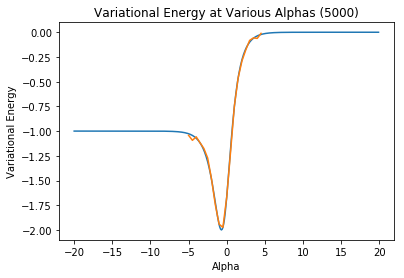

Optimal Alpha found at -0.5
Minimum Energy: -1.9746840828436814


In [185]:
## alphas = [i*0.05 for i in range(20,40)]
num_steps = 5000
alphas = [i*0.5 for i in range(-10,10)]
xs = np.asarray([i*0.1 for i in range(-200, 200)])
ys = np.asarray([ground_truth_variational_energy(x) for x in xs])

optimal_alpha, index, energies = get_optimal_alpha(alphas, num_steps=num_steps)

plt.plot(xs, ys)
plt.plot(alphas, energies)
# plt.xlim(1,2)
plt.ylim()
plt.ylabel("Variational Energy")
plt.xlabel("Alpha")
plt.title(f"Variational Energy at Various Alphas ({num_steps})")
plt.show()
print(f"Optimal Alpha found at {optimal_alpha}")
print(f"Minimum Energy: {energies[index]}")

# Apply Sorella's Method for Finding the Optimal Alpha 
#### (Instead of Searching the Entire Solution Space, we can apply steapest descent)

In [36]:
def get_variational_energy_derivative(E_var, alpha):
    """
    This function gets the derivative of the variational energy with
    respect to alpha. Currently, it just uses the expression I derived
    analytically, but it will need to be rewritten for the sake of 
    generalizability
    Args:
    - E_var (float) : Variational Energy
    - alpha (float) : alpha
    return:
    - derivative of E_var with respect to alpa (float)
    """
    a = 8*exp(-2*alpha) + 3*exp(-3*alpha)
    b = -2*exp(-1*alpha) - 3*exp(-3*alpha)
    denom = 4*exp(-1*alpha) + 2*exp(-3*alpha)
    return 2*(a - E_var*b)/denom

### Use these functions to test if our analytical expression is correct

In [37]:
def ground_truth_derivative(alpha):
    numerator = 4*exp(alpha)*(exp(alpha) + 2*exp(2*alpha) - 1)
    denominator = (2*exp(2*alpha) + 1) ** 2
    return numerator/denominator

In [47]:
test_alphas = np.asarray([i*0.1 for i in range(-200, 200)])
gt_eng = np.asarray([ground_truth_variational_energy(alpha) for alpha in test_alphas])
gt_der = np.asarray([ground_truth_derivative(alpha) for alpha in test_alphas])
model_der = np.asarray([get_variational_energy_derivative(ground_truth_variational_energy(alpha), alpha) for alpha in test_alphas])

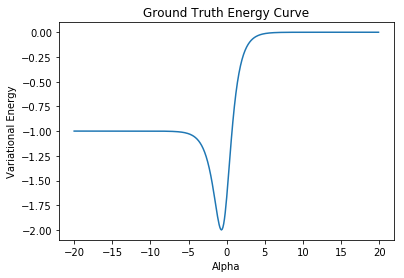

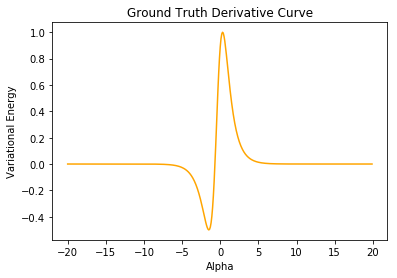

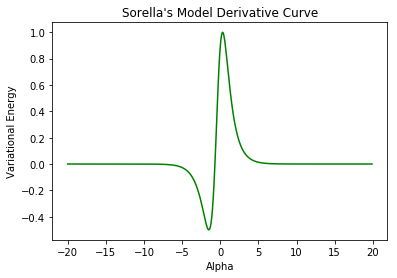

In [50]:
plt.plot(test_alphas, gt_eng)
plt.xlabel("Alpha")
plt.ylabel("Variational Energy")
plt.title("Ground Truth Energy Curve")
plt.show()

plt.plot(test_alphas, gt_der, color="orange")
plt.xlabel("Alpha")
plt.ylabel("Variational Energy")
plt.title("Ground Truth Derivative Curve")
plt.show()

plt.plot(test_alphas[0:400], model_der[0:400], color="green")
plt.xlabel("Alpha")
plt.ylabel("Variational Energy")
plt.title("Sorella's Model Derivative Curve")
plt.show()

In [49]:
model_der[np.argmin(gt_eng)]

-0.009105524512492481

In [38]:
print(f"Ground Truth")
alpha = 1

energy = get_variational_energy_test(alpha); print(f"Energy: {energy}")
gt = get_variational_energy_derivative_test(energy)
derivative = get_variational_energy_derivative_test(alpha); print(f"Derivative: {derivative}")

print("--"*10)
print("Analytical Function")
model = get_variational_energy_derivative(energy, alpha)
print(f"Model Prediction: {model}")

Ground Truth
Energy: -1.9738471015202512
Derivative: -0.1378153500111318
--------------------
Analytical Function
Model Prediction: -0.0037667815999372876
